## Aggregate performance analysis

**Procedure**
- Take a trained PPO model
- Evaluate model:
    - Single-agent mode (use policy to control a single-agent, the rest are expert-controlled)
    - Multi-agent mode (use policy to control all agents in the scene)

In [1]:
# Dependencies
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from utils.policies import load_policy
from pyvirtualdisplay import Display
import torch
import imageio
import matplotlib.pyplot as plt
from evaluation.policy_evaluation import evaluate_policy
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
import logging

### Configurations 

In [2]:
NUM_EVAL_EPISODES = 10_000 # Number of episodes to evaluate on

DETERMINISTIC = True 
SELECT_FROM = 100 # Number of test scenes
MAX_CONTROLLED_AGENTS = 200 # All agents are controlled
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']
VIDEO_PATH = '../evaluation/videos'

TRAIN_DATA_PATH = '../data_full/train'
TEST_DATA_PATH = '../data_full/valid'

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
models_config = load_config_nb("model_config") # Trained models

# Evaluation settings
EVAL_MODES = {'Self-play': 200, 'Log-replay': 1}
DATASETS = {'Train': TRAIN_DATA_PATH, 'Test': TEST_DATA_PATH}

### Helper functions 

In [3]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### **Expert** baseline

In [4]:
df_expert_replay = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TEST_DATA_PATH,
    mode='expert_replay',
    select_from_k_scenes=SELECT_FROM,
    num_episodes=100,
)

df_expert_replay['Agent'] = 'Expert'
df_expert_replay['Train agent'] = '-'
df_expert_replay['Dataset'] = '-'
df_expert_replay['Eval mode'] = 'Log-replay'

100%|██████████| 100/100 [00:05<00:00, 19.26it/s]


### Load df with results: **BC**, **PPO** and **HR-PPO**

In [4]:
df_res_all = pd.read_csv('../evaluation/paper/df_agg_performance_ip_0131.csv')
#df_res_extra_model = pd.read_csv('../evaluation/paper/df_agg_performance_ip_0131_extra_model.csv')

### Create aggregate performance table

In [5]:
H_COLUMNS = ['Agent', 'Train agent', 'Dataset', 'Eval mode']
METRICS = ['Off-Road Rate (\%)', 'Collision Rate (\%)', 'Goal Rate (\%)']

# Create table
df_all = pd.concat([
    df_expert_replay,
    df_res_all,
    #df_res_extra_model,
])

NameError: name 'df_expert_replay' is not defined

In [8]:
df_res_extra_model.rename(columns={'off_road': 'Off-Road Rate (\%)', 'veh_veh_collision': 'Collision Rate (\%)', 'goal_rate': 'Goal Rate (\%)'}, inplace=True)
df_res_extra_model.groupby(H_COLUMNS)[METRICS].mean() * 100

Off-Road Rate (\%)  \
Agent  Train agent Dataset Eval mode                        
HR-PPO Self-play   Test    Log-replay            4.600000   
                           Self-play             2.447745   

                                       Collision Rate (\%)  Goal Rate (\%)  
Agent  Train agent Dataset Eval mode                                        
HR-PPO Self-play   Test    Log-replay            19.800000       76.000000  
                           Self-play              6.738174       90.924092

In [12]:
# Off-Road Rate (\%) & Collision Rate (\%) & Goal Rate (\%)
df_all.rename(columns={'off_road': 'Off-Road Rate (\%)', 'veh_veh_collision': 'Collision Rate (\%)', 'goal_rate': 'Goal Rate (\%)'}, inplace=True)

In [13]:
df_all[df_all['Agent'] == 'HR-PPO']

,scene_id,veh_id,num_total_vehs,Goal Rate (\%),Off-Road Rate (\%),Collision Rate (\%),Agent,Train agent,Dataset,Eval mode,veh_int_paths,tot_int_paths,Reg. weight
16762,tfrecord-00679-of-01000_121.json,1,16,1.0,0.0,0.0,HR-PPO,Self-play,Train,Self-play,0.0,0.0,0.025
16763,tfrecord-00679-of-01000_121.json,6,16,1.0,0.0,0.0,HR-PPO,Self-play,Train,Self-play,0.0,0.0,0.025
16764,tfrecord-00679-of-01000_121.json,9,16,1.0,0.0,0.0,HR-PPO,Self-play,Train,Self-play,0.0,0.0,0.025
16765,tfrecord-00679-of-01000_121.json,10,16,1.0,0.0,0.0,HR-PPO,Self-play,Train,Self-play,0.0,0.0,0.025
16766,tfrecord-00679-of-01000_121.json,22,16,1.0,0.0,0.0,HR-PPO,Self-play,Train,Self-play,0.0,0.0,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4131,tfrecord-00099-of-00150_264.json,18,8,1.0,0.0,0.0,HR-PPO,Self-play,Test,Log-replay,0.0,0.0,0.025
4132,tfrecord-00003-of-00150_36.json,0,2,0.0,0.0,1.0,HR-PPO,Self-play,Test,Log-replay,0.0,0.0,0.025
4133,tfrecord-00098-of-00150_120.json,4,2,0.0,0.0,1.0,HR-PPO,Self-play,Test,Log-replay,0.0,0.0,0.025
4134,tfrecord-00028-of-00150_100.json,9,3,1.0,0.0,0.0,HR-PPO,Self-play,Test,Log-replay,0.0,0.0,0.025


In [14]:
agg_tab = df_all.groupby(H_COLUMNS)[METRICS].mean() * 100
agg_tab.reindex(['Expert', 'BC', 'PPO', 'HR-PPO'], level=0).style.format("{:.2f}")

In [17]:
print((agg_tab.style.format(precision=1)).to_latex())

\begin{tabular}{llllrrr}
 &  &  &  & Off-Road Rate (\%) & Collision Rate (\%) & Goal Rate (\%) \\
Agent & Train agent & Dataset & Eval mode &  &  &  \\
\multirow[c]{4}{*}{BC} & \multirow[c]{4}{*}{-} & \multirow[c]{2}{*}{Test} & Log-replay & 19.2 & 10.7 & 39.0 \\
 &  &  & Self-play & 13.4 & 11.1 & 42.3 \\
 &  & \multirow[c]{2}{*}{Train} & Log-replay & 16.8 & 10.3 & 37.5 \\
 &  &  & Self-play & 11.8 & 10.3 & 42.8 \\
Expert & - & - & Log-replay & 0.8 & 3.5 & 41.8 \\
\multirow[c]{4}{*}{HR-PPO} & \multirow[c]{4}{*}{Self-play} & \multirow[c]{2}{*}{Test} & Log-replay & 2.9 & 21.5 & 76.5 \\
 &  &  & Self-play & 2.2 & 6.5 & 91.6 \\
 &  & \multirow[c]{2}{*}{Train} & Log-replay & 2.3 & 23.5 & 74.3 \\
 &  &  & Self-play & 2.0 & 5.8 & 92.6 \\
\multirow[c]{4}{*}{PPO} & \multirow[c]{4}{*}{Self-play} & \multirow[c]{2}{*}{Test} & Log-replay & 3.3 & 22.7 & 74.0 \\
 &  &  & Self-play & 2.6 & 6.9 & 90.8 \\
 &  & \multirow[c]{2}{*}{Train} & Log-replay & 1.9 & 25.4 & 72.7 \\
 &  &  & Self-play & 1.8 & 5.8 &

## 2. Display scenes with # intersecting paths

In [18]:
models_config.best_overall_models[0].name

'policy_L0.0_S1000_I1212'

In [17]:
models_config.best_overall_models[1]

Box({'name': 'policy_L0.02_S1000_I1654', 'reg_weight': 0.02, 'agent': 'HR-PPO', 'train_agent': 'Self-play', 'wandb_run': 'magic-frost-373'})

INFO:root:No regularization weight specified, using default PPO.
INFO:root:No regularization weight specified, using default PPO.


In [6]:
TEST_DATA_PATH = '../data_full/valid'
video_config = load_config_nb("video_config")

In [50]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/valid_all_01_23_11_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)
    
# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [56]:
df_intersect

,traffic_scene,veh_id,intersecting_paths
0,tfrecord-00000-of-00150_101.json,2,0
1,tfrecord-00000-of-00150_101.json,14,0
2,tfrecord-00000-of-00150_101.json,24,0
3,tfrecord-00000-of-00150_101.json,28,0
4,tfrecord-00000-of-00150_101.json,29,0
...,...,...,...
84648,tfrecord-00149-of-00150_93.json,29,0
84649,tfrecord-00149-of-00150_93.json,60,0
84650,tfrecord-00149-of-00150_93.json,73,0
84651,tfrecord-00149-of-00150_94.json,0,0


In [82]:
NUM_INTERSECTING_PATHS = 2

VIDEO_PATH = f'../evaluation/videos/intersecting_paths_{NUM_INTERSECTING_PATHS}'

# Sample a random scene
random_scene = df_intersect[df_intersect['intersecting_paths'] == NUM_INTERSECTING_PATHS].sample(n=1) 

scene_name = str(random_scene.traffic_scene.values[0])
focus_veh_id = random_scene.veh_id.values[0]
print(random_scene)

                          traffic_scene veh_id intersecting_paths
39231  tfrecord-00069-of-00150_276.json     14                  2


In [88]:
MODEL = "PPO"

if MODEL == "PPO":
    policy = RegularizedPPO.load(
    f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[0].name}'
)

elif MODEL == "HR-PPO": 
    policy = RegularizedPPO.load(
        f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[2].name}'
    )        

env_config.data_path = TEST_DATA_PATH
env_config.max_num_vehicles = 1
env = BaseEnv(env_config)

obs_dict = env.reset(filename=scene_name)
frames = []

for time_step in range(100):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 2 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                source=env.controlled_vehicles[0],
                view_width=120,
                view_height=120,
                rotate_with_source=True,
            )
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break

INFO:root:No regularization weight specified, using default PPO.


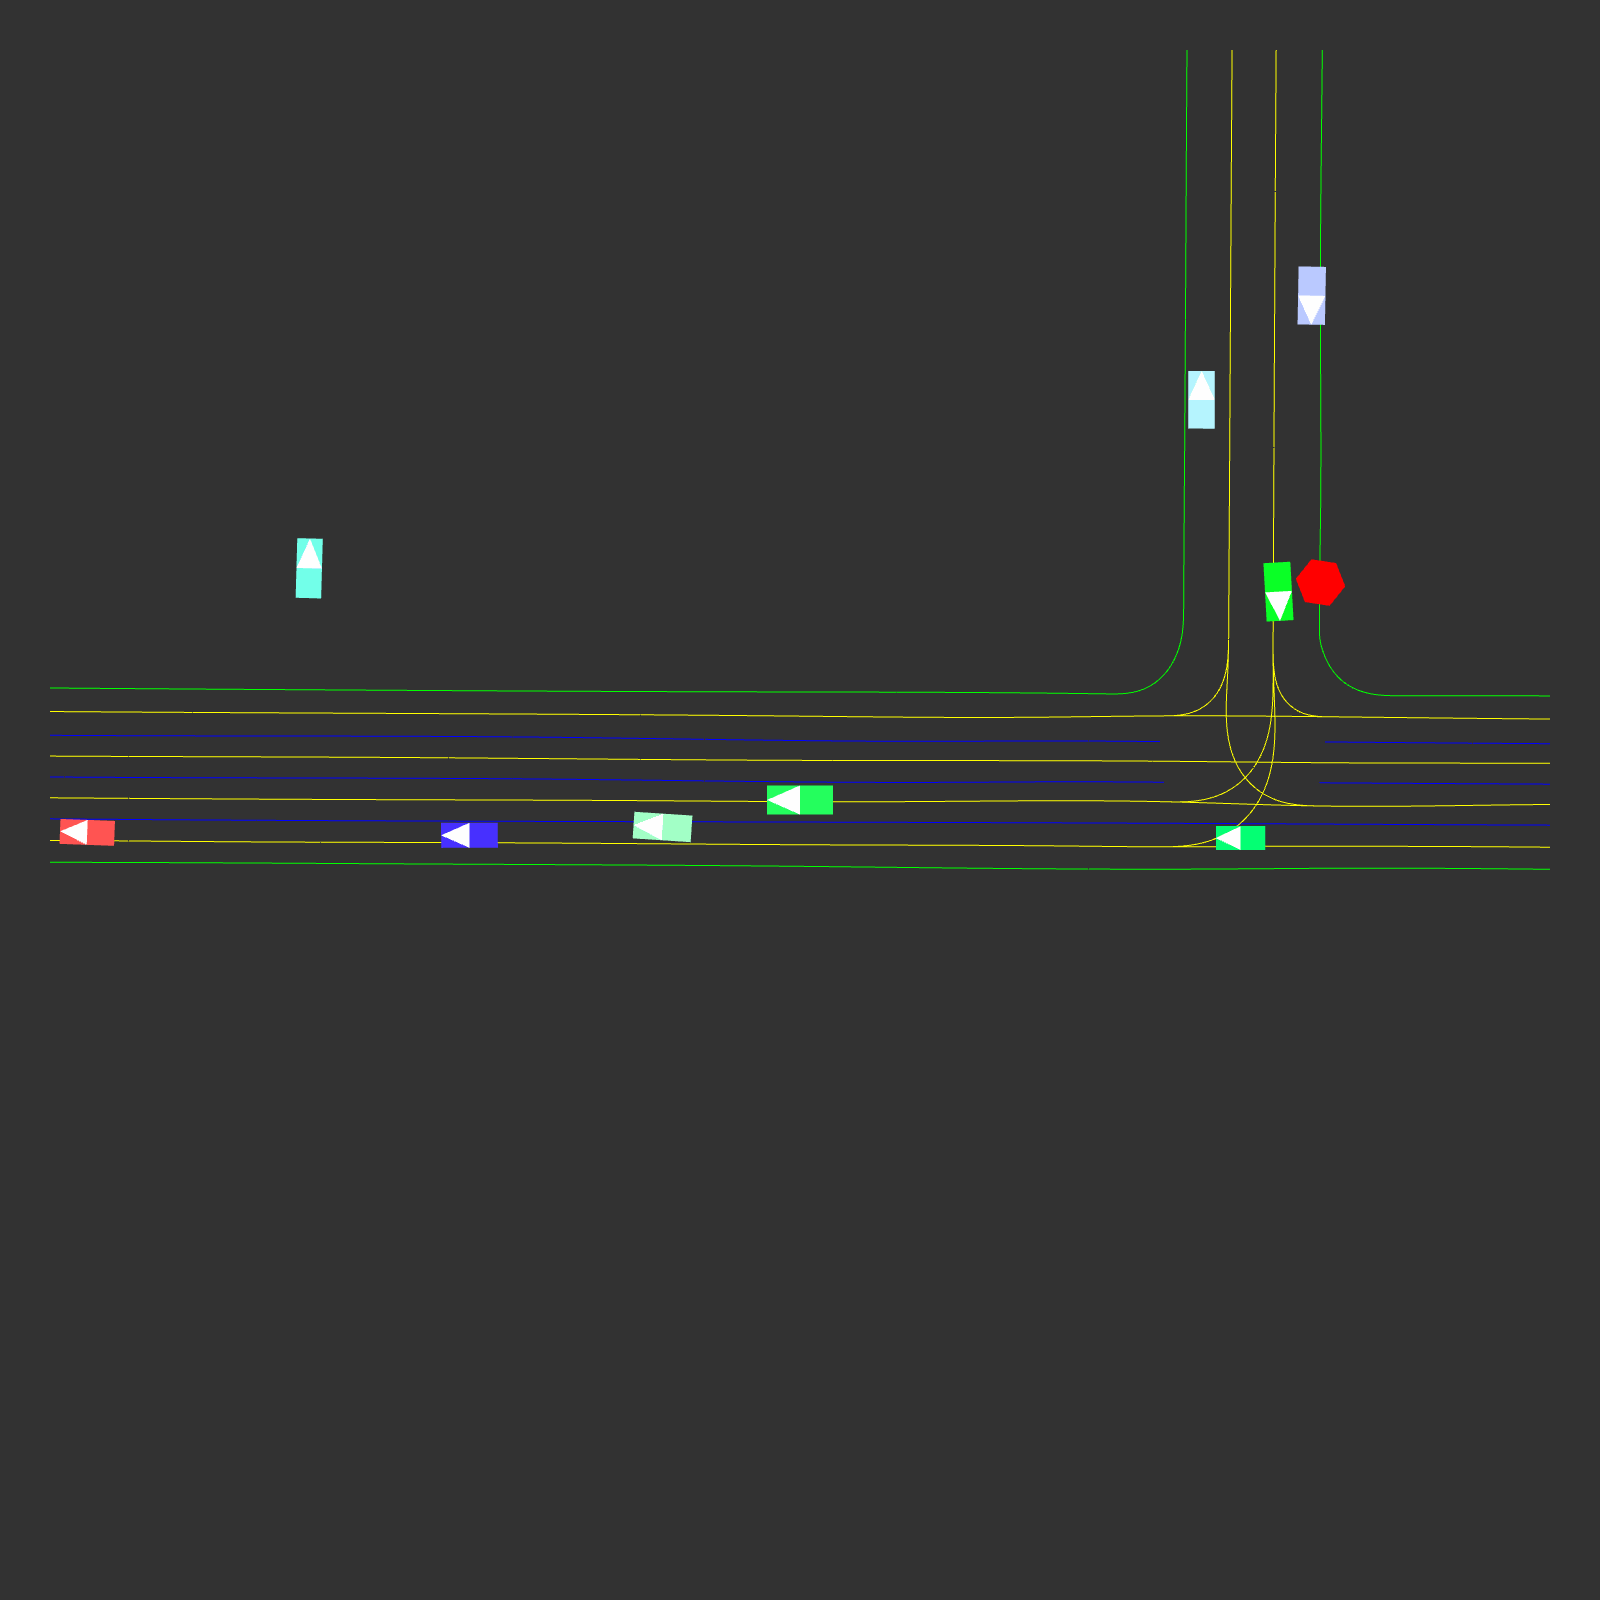

In [89]:
Path(f"{VIDEO_PATH}/{SCENE_NAME}_{MODEL}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{SCENE_NAME}_{MODEL}.gif", fps=4)
display(HTML(f"<h3>{MODEL} - {SCENE_NAME}</h3>"))
display_gif(f"{VIDEO_PATH}/{SCENE_NAME}_{MODEL}.gif")

In [15]:
# Path(f"{VIDEO_PATH}/{scene_name}").parent.mkdir(parents=True, exist_ok=True)
# create_video(frames, f"{VIDEO_PATH}/{scene_name}.gif", fps=4)
# display(HTML(f"<h3>{scene_name}</h3>"))
# display_gif(f"{VIDEO_PATH}/{scene_name}.gif")